# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание признаков:**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

**Целевой признак**
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import time
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Выведем долю пропущенных значений в каждом признаке датасета.

In [5]:
data.isna().mean() #.sort_values()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Наблюдаем большое количество пропусков в датафрейме. Посмотрим сколько данных останется, если удалть все строки, где есть хоть одно пропущенное значение.

In [6]:
len(data.dropna()) / len(data)

0.6936667710776055

При удалении всех пропусков останется только 69% данных, поэтому в дальнейшем по каждому признаку обратаем пропуски чтобы не терять так много данных.  
В дальнейшем вначале проанализируем признаки без пропусков, чтобы удалить аномалии. Затем перейдем к признакам с пропусками.

Посмотрим общую статистическую информацию о численных признаках.

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- В признаке Price имеются нулевые значения, что выглядит аномально;
- В признаке RegistrationYear минимальный год 1000 а максимальный 9999, что является артефактами, которые требуется удалить;
- В признаке Power имеются аномальные нулевые значения, а так же значения с мощностью 20000. В дальнейшем избавимся от этих сэмплов;
- Признаки Kilometer, RegistrationMonth выглядят правдоподобно. Признак RegistrationMonth возможно не представляет ценность для построения модели;
- Признак NumberOfPictures имеет только нулевые значения, следовательно не несет никакой информативности;
- Признак PostalCode почтовый индекс владельца анкеты (пользователя) вряд ли несет полезную информацию для построения модели.

Удалим колонки NumberOfPictures и PostalCode из датафрема.

In [8]:
df = data.drop(['NumberOfPictures', 'PostalCode'], axis=1)

Обработаем дубликаты.

In [9]:
df.duplicated().sum()

5

In [10]:
df = df.drop_duplicates()

### Анализ признаков

#### Признак DateCrawled

Приведем признак DateCrawled к формату даты и посмотрим разброс значений по годам и месяцам. Если будут объекты скаченные в разные года, то имело бы смысл использовать эти данные как признак. Например автомобиль 2015 года выпуска, в 2016 году будет стоить дорожем, чем тот же автомобиль в 2020 году).

In [11]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')

In [12]:
df['DateCrawled'].dt.year.value_counts()

2016    354364
Name: DateCrawled, dtype: int64

In [13]:
df['DateCrawled'].dt.year.max()

2016

In [14]:
df['DateCrawled'].dt.month.value_counts()

3    296820
4     57544
Name: DateCrawled, dtype: int64

Предположение не оправдалось, все объекты скачены в 2016 году, с разницей в два месяца максимум. Будем считать что за два месяца рынок существенно не изменился и цены не изменились, поэтому данные к колонке DateCrawled не несут полезной информации для модели. 

#### Признак Price

Посмотрим на гисторамму.

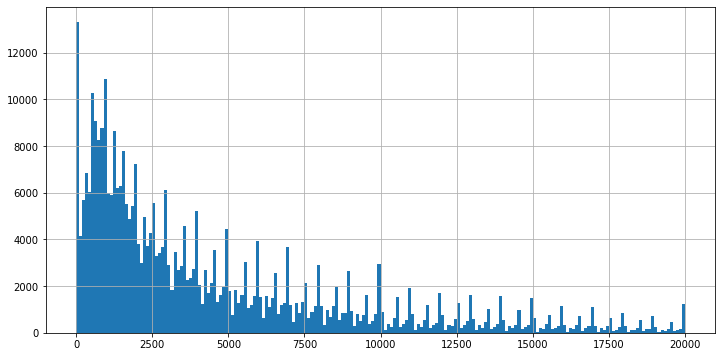

In [15]:
df['Price'].hist(bins=200, figsize=[12,6])

Имеется пик значений при цене около нуля, который выглядит аномальною Трудно представить необходимость предсказывать нулевую цену автомобиля. Посмотрим распределение объектов с ценой до 150 евро включительно.

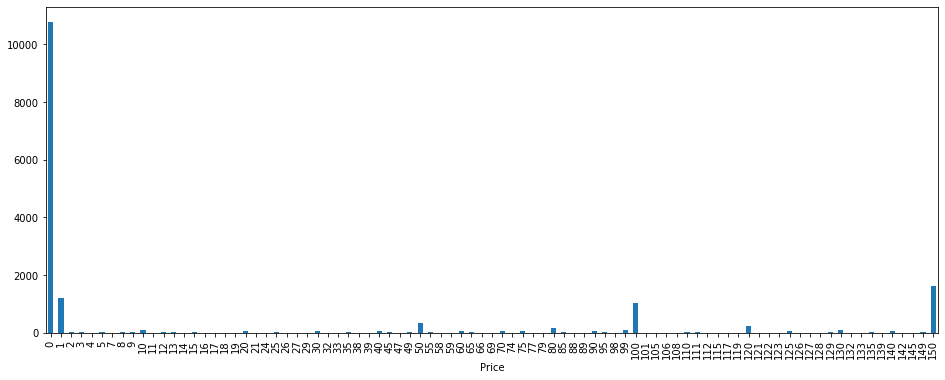

In [16]:
df[df['Price'] <= 150].groupby('Price')['Price'].count().plot(kind='bar', figsize=[16,6])

Видим аномальный выбросы при цене менее 1 евро. Заполнять эти аномалии не будем, так как это целевой признак. Объектов с ценой менее 100 евро немного, такая цена выглядят малореалистичной, поэтому удалим этим объекты из датасета. 

In [17]:
df = df[df['Price'] > 100]

#### Признак RegistrationYear

Построим ящик с усами для признака.

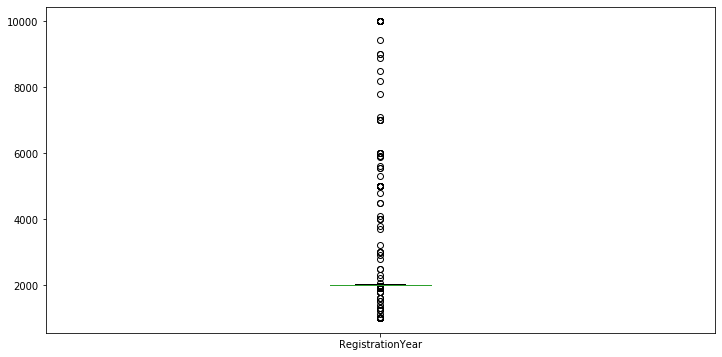

In [18]:
df['RegistrationYear'].plot.box(figsize=[12,6])

Наблюдаеются аномальные значения. Год регистрации автомобиля явно не может быть больше 2016 (год выгрузки данных) и меньше 1885 (первый в мире автомобиль с двигателем внутреннего сгорания). 

Удалим выбросы в признаке RegistrationYear нижней границы возьмем 0,01 квантиль и потряем не более 1% корректных данных. Проведем исключение объектов по условиям:
- год регистрации автомобиля равен году скачивания данных и месяц регистрации автомобиля болье месяца скачивания данных;
- год регистрации авто больше года скачивания анкеты;
- год регистрации авто меньше значения 0,01 квантиля признака года регистрации.

In [19]:
min_year = df['RegistrationYear'].quantile(q=0.01, interpolation='linear')
min_year

1980.0

In [20]:
df = df[~(
    (df['RegistrationYear']==df['DateCrawled'].dt.year.max()) & (df['RegistrationMonth'] >= df['DateCrawled'].dt.month)
    ) & (df['RegistrationYear'] <= df['DateCrawled'].dt.year) &  (
        df['RegistrationYear'] >= min_year)]

In [21]:
df.shape

(317772, 14)

Посмотрим на боксплот после очистки от аномалий.

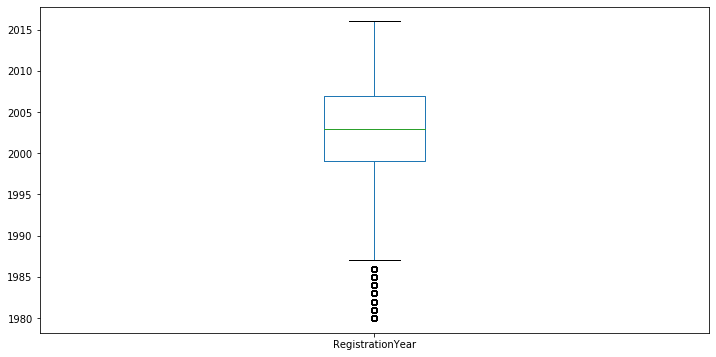

In [22]:
df['RegistrationYear'].plot.box(figsize=[12,6])

Построим диаграмму зависимости средней цены авто от года регистрации.

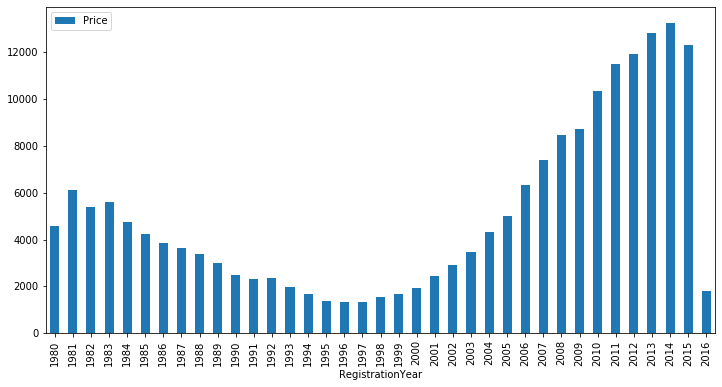

In [23]:
df.groupby('RegistrationYear')['Price'].mean().plot(kind='bar', figsize=[12,6], legend=True)

#### Признак Power

Построим боксплот.

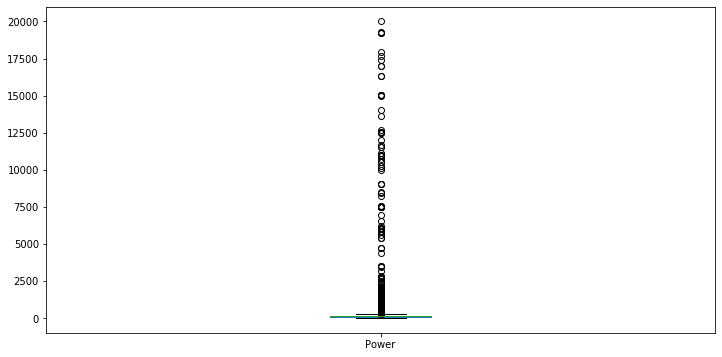

In [24]:
df['Power'].plot.box(figsize=[12,6])

По боксплоту видим большое число неправдоподобно больших значений мощности автомобилей. 

Посмотрим на количество объектов с 50-ю наименьшими значениями мощности.

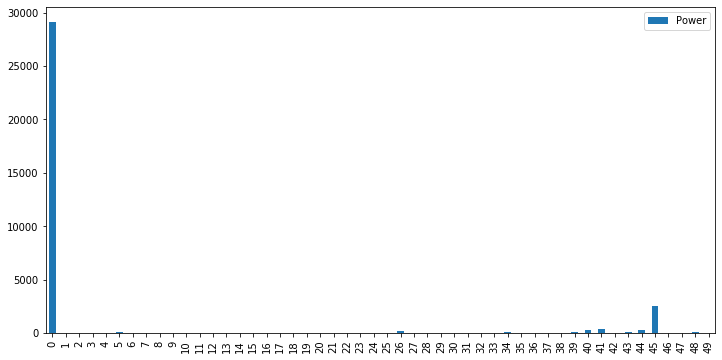

In [25]:
df['Power'].value_counts().sort_index().head(50).plot(kind='bar', figsize=[12,6], legend=True)

Около 35000 объектов с нулевой мощность. Также есть крайне редкие и не очень правдоподобные сэмплы в дипазоне от 0 до 45 л. с. Удалим их.

In [26]:
df = df[df['Power'] >= 45]

В качестве первой итерации определения верхней границы мощности для очистки данных примем 1000 л.с. Построим гисторамму.

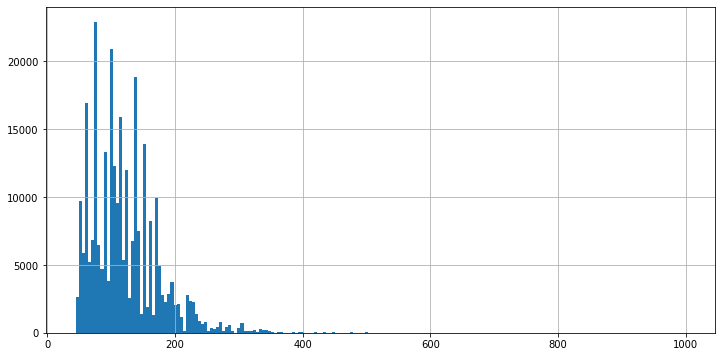

In [27]:
df[df['Power'] < 1000]['Power'].hist(bins=200, figsize=[12,6])

По гисторамме видим, что значения больше 350 л. с. встречаются крайне редко и нерегулярно. Посмотрим какой это процентиль наших данных, чтобы численно видеть сколько процентов данных мы потеряем, если отфильруем признак по этому значению.

In [28]:
stats.percentileofscore(df['Power'], 350)

99.63181559734474

Почти 99,6% данных имеют мощность до 350 л.с., то есть потери при фильтрации составлят менее 1%, принимаем это допустимым и фильтруем по вернему границе.

In [29]:
df = df[df['Power'] < 350]

Посмотрим на гистограмму признака Power после очистки данных.

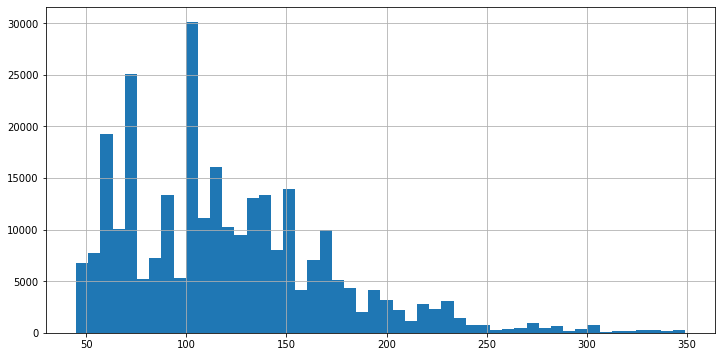

In [30]:
df['Power'].hist(bins=50, figsize=[12,6])

#### Признак Kilometer

Построим гисторамму.

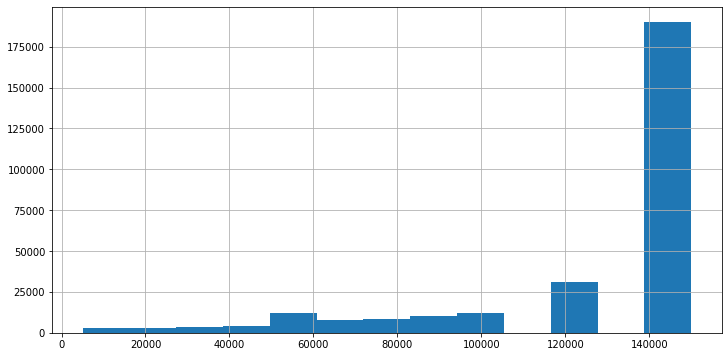

In [31]:
df['Kilometer'].hist(bins=13, figsize=[12,6])

In [32]:
df['Kilometer'].value_counts().count()

13

Странно что отстствуют атомобили с пробегом 110 и 130 тыс. км. 
Видим что максимальный пробег ограничивается 150000 тыс. км. Вероятно это максимальное число, которое возможно добавить в анкету, но действительный пробег может быть больше. Добавим категориальный признак max_km в котором значение 1 будет у актомобилей с пробегом 150000 тыс. км, а у остальных 0.  
Для каждого признака разделим пробег на 150000 и округлим в меньшую строному присвоив тим int. 

In [33]:
df['max_km'] = (df['Kilometer'] / 150000).astype('int')

In [34]:
df[['Kilometer', 'max_km']].head()

,Kilometer,max_km
1,125000,0
2,125000,0
3,150000,1
4,90000,0
5,150000,1


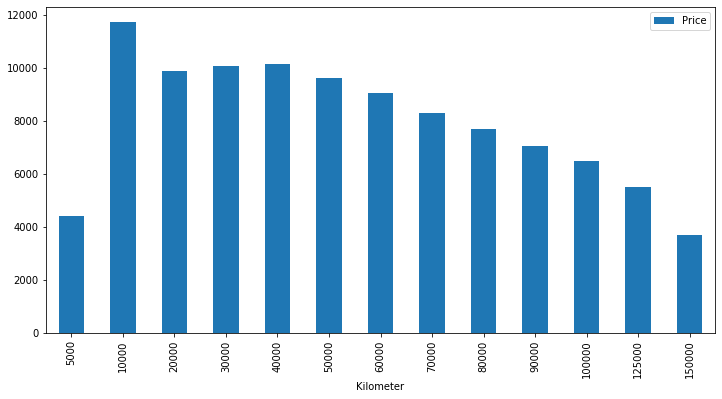

In [35]:
df.groupby('Kilometer')['Price'].mean().plot(kind='bar', figsize=[12,6], legend=True)

#### Признак RegistrationMonth 

Посмотрим количество уникальных значений признака.

In [36]:
df['RegistrationMonth'].value_counts().count()

13

Признак означает месяц регистрации автомобиля и при этом уникальных значений 13, а не 12. Не поддается пониманию. 

Посмотрим распределение.

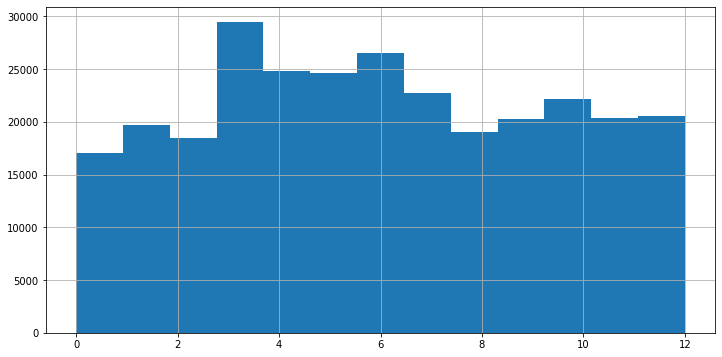

In [37]:
df['RegistrationMonth'].hist(bins=13, figsize=[12,6])

Построим график средней цены автомобиля в зависимости от месяца регистрации.

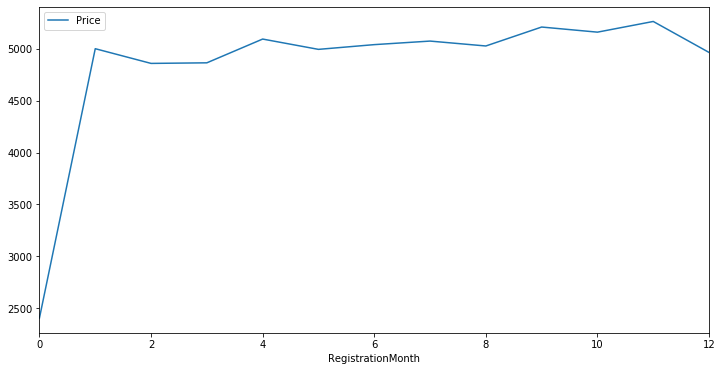

In [38]:
df.groupby('RegistrationMonth')['Price'].mean().plot(kind="line", figsize=[12,6], legend=True)

В некий нулевой месяц среднее значение целевого признака (цены) почти в два раза ниже чем в другие месяцы. Выглядит аномально. Запомним фрагмент датафрейма с нелевым месяцем, возможно в дальнейшем удалим значения по индексу.  

In [39]:
bad_month = df[df['RegistrationMonth']==0]

In [40]:
bad_month.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,max_km
count,17049.000000,17049.000000,17049.000000,17049.000000,17049.0,17049.000000
mean,2405.934424,2000.713649,110.883864,136432.048801,0.0,0.796586
std,2956.438312,6.654157,48.112051,33242.838579,0.0,0.402549
min,105.000000,1980.000000,45.000000,5000.000000,0.0,0.000000
25%,600.000000,1997.000000,75.000000,150000.000000,0.0,1.000000
50%,1300.000000,2000.000000,102.000000,150000.000000,0.0,1.000000
75%,2999.000000,2004.000000,140.000000,150000.000000,0.0,1.000000
max,20000.000000,2016.000000,349.000000,150000.000000,0.0,1.000000


#### Признаки Brand / Model

Заполним пропуски в признаке модой группировки по бренду и мощности.

In [41]:
df['Model'] = df.groupby(
    ['Brand', 'Power'])['Model'].transform(
    lambda x: x.fillna((x.mode()[0] if not x.mode().empty else np.nan))
)

Посмотрим сколько значений не удалось заполнить.

In [42]:
df[df['Model'].isna()].shape[0]

1346

Посмотрим какие бренды не удается заполнить.

In [43]:
df[df['Model'].isna()]['Brand'].value_counts()

sonstige_autos    1246
honda                7
rover                7
mazda                7
audi                 5
fiat                 5
alfa_romeo           4
mercedes_benz        4
toyota               4
daewoo               4
nissan               4
chrysler             4
volvo                3
land_rover           3
trabant              3
hyundai              3
opel                 3
peugeot              3
bmw                  3
ford                 3
jeep                 2
smart                2
citroen              2
saab                 2
lancia               2
skoda                2
subaru               1
lada                 1
porsche              1
chevrolet            1
volkswagen           1
kia                  1
mitsubishi           1
suzuki               1
seat                 1
Name: Brand, dtype: int64

Почти все незаполненные значения признака Model приходятся на бренд sonstige_autos. Посмотрим какой модельный ряд у него имеется.

In [44]:
df[df['Brand'] == 'sonstige_autos']['Model'].value_counts(dropna=False)

NaN    1246
Name: Model, dtype: int64

Ниакаких моделей. Значит оставим в датафрейме только объекты с заполненными моделями или с брендом sonstige_autos, чтобы в дальнейшем заполнить его вручную. 

In [45]:
df = df[(~df['Model'].isna()) | (df['Brand'] == 'sonstige_autos')]

Заполним пропуски, которые остались только у бренда sonstige_autos на модель other.

In [46]:
df['Model'] = df['Model'].fillna('other')

Создадим признак совмещающий Brand и Model.

In [47]:
df['Brand_Model'] = df['Brand'] + '_' + df['Model']
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,LastSeen,max_km,Brand_Model
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50,0,audi_a4
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46,0,jeep_grand
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17,1,volkswagen_golf
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21,0,skoda_fabia
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,2016-04-06 19:17:07,1,bmw_3er


#### Признак VehicleType

Построим столбчатую диаграмму значений признака.

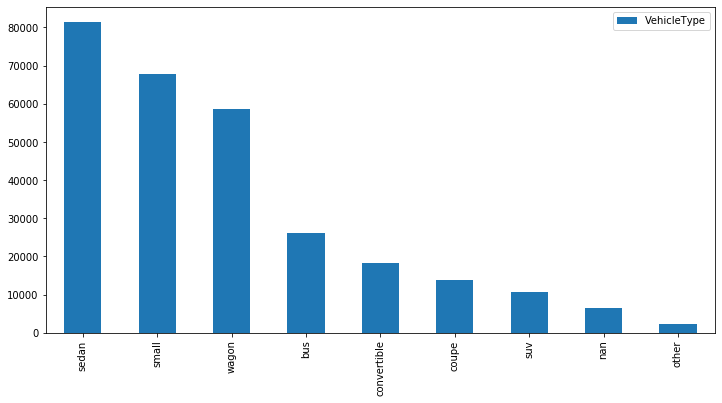

In [48]:
df['VehicleType'].value_counts(dropna=False).plot(kind='bar', figsize=[12,6], legend=True)

Имеется около 20 000 объектов с пропущенным значением. Признак VehicleType означает тип автомобильного кузова, поэтому попробуем заполнить его используя значение моды при группировки по модели автомобиля.  

In [49]:
df['VehicleType'] = df.groupby(['Brand_Model'], sort=False)['VehicleType'].apply(lambda x: x.fillna(x.mode().iloc[0]))

Посмотрим на диаграмму после заполнения пропусков.

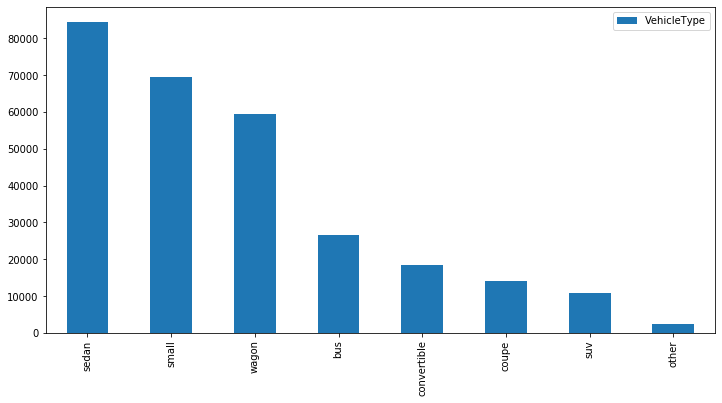

In [50]:
df['VehicleType'].value_counts(dropna=False).plot(kind='bar', figsize=[12,6], legend=True)

Посмотрим зависит ли средняя цена на автомобиль от типа кузова. 

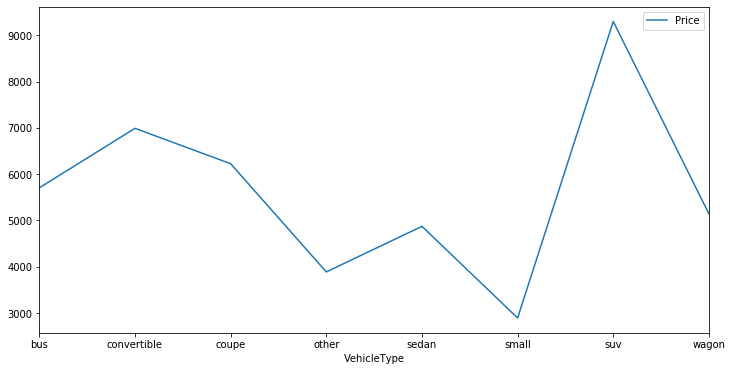

In [51]:
df.groupby('VehicleType')['Price'].mean().plot(kind="line", figsize=[12,6], legend=True)

Тип кузова вляет на цену, значит будем использовать его для обучения моделей.

#### Признак FuelType

Посмотрим уникальные значение в признаке.

In [52]:
df['FuelType'].value_counts(dropna=False)

petrol      180672
gasoline     86478
NaN          13034
lpg           4568
cng            473
hybrid         198
other           52
electric        34
Name: FuelType, dtype: int64

Заполним пропуски модой по признаку Brand_Model.

In [53]:
df['FuelType'] = df.groupby(['Brand_Model'], sort=False)['FuelType'].apply(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

Проверим отсутствие пропусков.

In [54]:
df[df['FuelType'].isna()].shape[0]

0

#### Признак Gearbox 

Смотрим значения.

In [55]:
df['Gearbox'].value_counts(dropna=False)

manual    224193
auto       56576
NaN         4740
Name: Gearbox, dtype: int64

Заполняем модой по Brand_Model и проверяем.

In [56]:
df['Gearbox'] = df.groupby(['Brand_Model'], sort=False)['Gearbox'].apply(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))

In [57]:
df[df['Gearbox'].isna()].shape[0]

0

#### Признак NotRepaired

Смотрим уникальные значения.

In [58]:
df['NotRepaired'].value_counts(dropna=False)

no     218608
NaN     39688
yes     27213
Name: NotRepaired, dtype: int64

Достоверно заполнить не получится, поэтому заменим пропуски категорийным значением unknown.

In [59]:
df = df.replace(np.nan, 'unknown')

#### Признак DateCreated

Приведем к формату даты.

In [60]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')

Смотрим диапазон создания анкет в годах.

In [61]:
df['DateCreated'].dt.year.value_counts()

2016    285486
2015        23
Name: DateCreated, dtype: int64

На основании года анкеты строить признак не имеет смысла из-за превалирования одного значения из двух.  
Посмотрим на месяца.

In [62]:
df['DateCreated'].dt.month.value_counts()

3     238758
4      46327
2        344
1         58
12         9
11         8
9          3
8          2
Name: DateCreated, dtype: int64

Признак месяца создания анкеты так же несбалансирован и не окажет влияния на обучение моделей, поэтому удаляем колонку DateCreated из признаков датасета.

In [63]:
df = df.drop(['DateCreated'], axis=1)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,LastSeen,max_km,Brand_Model
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-04-07 01:46:50,0,audi_a4
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-04-05 12:47:46,0,jeep_grand
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 17:40:17,1,volkswagen_golf
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-04-06 10:17:21,0,skoda_fabia
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-06 19:17:07,1,bmw_3er


#### Признак LastSeen  
Колонку с датой последней активности пользователя удаляем, так как это информация о поведении пользователя, а не признаках автомобиля.

In [64]:
df = df.drop(['LastSeen'], axis=1)

### Выделение признаков и целевых признаков. 

Построим тепловую карту матрицы линейной корреляции.

In [65]:
def corr_heatmap(df):
    df_corr = df.corr().replace(1,0)

    mask = np.zeros_like(df_corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize=(18, 7))

    sns.heatmap(df_corr, mask=mask, annot=True, fmt=".5f", linewidths=.1, cmap= 'coolwarm')
    plt.title('Матрица коэффициентов линейной корреляции', fontsize=15)
    plt.ylabel('Признак', fontsize=15)
    plt.xlabel('Признак', fontsize=15)

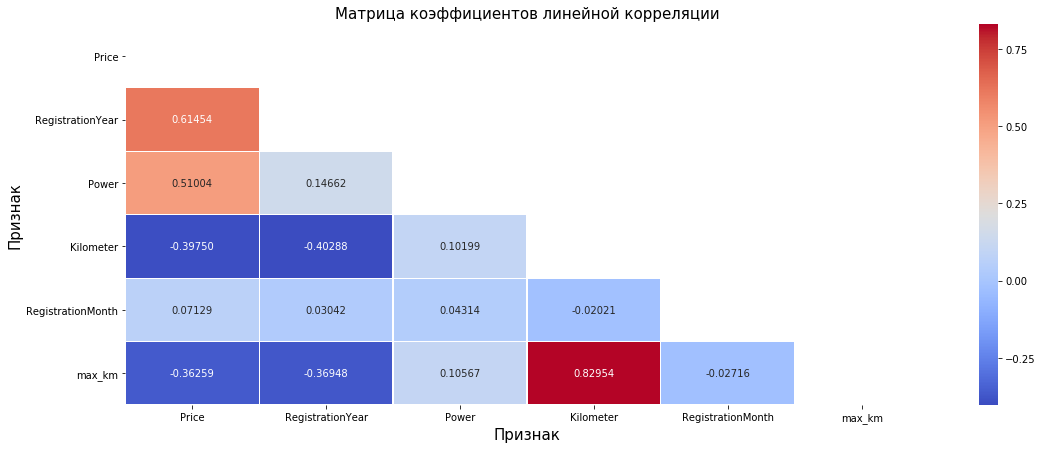

In [66]:
corr_heatmap(df)

In [67]:
#sns.pairplot(df[['Price','RegistrationYear','Power','Kilometer']], kind='scatter', plot_kws={'alpha':0.1})

Выделим признаки и целевые признаки.

In [68]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Brand_Model', 'max_km']
num_features = ['RegistrationYear','Power','Kilometer']

Для применения на модели LinearRegression кодируем категориальные признаки методом OHE. 

In [69]:
X_ohe = pd.get_dummies(df[cat_features], drop_first=True).astype('int')

In [70]:
X_ohe = df[num_features].join(X_ohe)

Для моделей CatBoostRegressor и LightGBM кодируем категориальные признаки методом Ordinal Encoding.

In [71]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(
    encoder.fit_transform(df[cat_features]), columns=df[cat_features].columns, index=df[cat_features].index)

In [72]:
X_oe = df[num_features].join(data_ordinal).astype('int')

Выделяем целевой признак.

In [73]:
y = df[['Price']]

Масштабирование признаков проводить не будем, для линейной регрессии используем гиперпараметр normalize=True, а для остальных моделей масштабы признаков не повлиют на обучение.

Разобъем выборку на обучающие и тестовые признаки для каждого типа кодировки.

 Для использования в линейной регрессии ohe.

In [74]:
X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=0.25, random_state=1234)

Для CatBoostRegressor и LightGBM oe.

In [75]:
X_train_oe, X_test_oe, y_train, y_test = train_test_split(X_oe, y, test_size=0.25, random_state=1234)

### Вывод 
В результате предобработки данных:
- Удалили дубликаты.
- Проанализировали признаки. Пропущенные значения в категориальных признаках при возможности заполнены модой по группировке другими признаками.
- Аномальные значения удалены, в том числе в целевом признаке, при цене менее 100 евро. 
- Добавлен категориальный признак совмещающий в себе бренд и модель автомобиля.
- Добавлен категориальный признак, при пробеге равном 150000 км, так как исходя из анализа данных выдвинуто предположение, что это максимальное значений, которое можно было указать в анкете.
- Определены признаки, необходимые для построения моделей.
- Категориальные признаки для построения моделей линейной регрессии закодированы методом Ordinal Encoding, для остальных моделей методом one-hot encoding.
- Данные разделены на тестовую и обучающую выборки в соотношении 1:4.

## Обучение моделей

### Модели с базовыми параметрами.

Создадим функцию которая на вход получает модель, признаки и таргеты, а возвращает время обучения, время предсказания и RMSE.

In [76]:
def time_score(model, X_train, y_train, X_test, y_test):
    
    start = time.time()    
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()  
    predict = model.predict(X_test)
    predict_time = time.time() - start

    return train_time, predict_time, mean_squared_error(y_test, predict)**0.5

Создадим список в котором буду храниться результаты тестирования моделей.

In [77]:
result = []

Применим функцию получения тестовых метрик моделей для моделей с гиперпараметрами по умолчанию. 

####  LinearRegression

In [78]:
result.append(time_score(LinearRegression(), X_train_ohe, y_train, X_test_ohe, y_test))

In [79]:
result

[(24.770498275756836, 0.1971573829650879, 2357.579074550216)]

####  LGBMRegressor

In [80]:
result.append(time_score(
    LGBMRegressor(verbose=0, seed=12345), X_train_oe, y_train, X_test_oe, y_test))

####  CatBoostRegressor

In [81]:
result.append(time_score(
    CatBoostRegressor(silent=True, random_seed=12345, cat_features=cat_features), X_train_oe, y_train, X_test_oe, y_test))

### Тюнинг моделей

С помощью GridSearchCV с кросвалидацией по 3-м фолдам проведем поиск гиперпараметров для моделей LGBMRegressor и CatBoostRegressor.

#### LGBMRegressor tuning

In [82]:
lgbm = LGBMRegressor(verbose=0, seed=12345)

params = {
    'learning_rate': [0.15, 0.17],
    'n_estimators': [200, 300],
    'num_leaves': [41, 51],
}

grid_lgbm = GridSearchCV(lgbm, params, cv=3, scoring='neg_mean_squared_error', verbose=3)

In [83]:
%%time
grid_lgbm.fit(X_train_oe, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] learning_rate=0.15, n_estimators=200, num_leaves=41 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.15, n_estimators=200, num_leaves=41, score=-2317760.436, total=10.1min
[CV] learning_rate=0.15, n_estimators=200, num_leaves=41 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.1min remaining:    0.0s


[CV]  learning_rate=0.15, n_estimators=200, num_leaves=41, score=-2346909.300, total= 1.6min
[CV] learning_rate=0.15, n_estimators=200, num_leaves=41 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.7min remaining:    0.0s


[CV]  learning_rate=0.15, n_estimators=200, num_leaves=41, score=-2298586.260, total=  55.7s
[CV] learning_rate=0.15, n_estimators=200, num_leaves=51 .............
[CV]  learning_rate=0.15, n_estimators=200, num_leaves=51, score=-2286814.697, total= 1.0min
[CV] learning_rate=0.15, n_estimators=200, num_leaves=51 .............
[CV]  learning_rate=0.15, n_estimators=200, num_leaves=51, score=-2323013.972, total=  59.7s
[CV] learning_rate=0.15, n_estimators=200, num_leaves=51 .............
[CV]  learning_rate=0.15, n_estimators=200, num_leaves=51, score=-2254670.748, total=  57.1s
[CV] learning_rate=0.15, n_estimators=300, num_leaves=41 .............
[CV]  learning_rate=0.15, n_estimators=300, num_leaves=41, score=-2267910.255, total= 1.2min
[CV] learning_rate=0.15, n_estimators=300, num_leaves=41 .............
[CV]  learning_rate=0.15, n_estimators=300, num_leaves=41, score=-2292679.240, total= 1.3min
[CV] learning_rate=0.15, n_estimators=300, num_leaves=41 .............
[CV]  learning_r

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 26.6min finished


CPU times: user 26min 33s, sys: 5.94 s, total: 26min 39s
Wall time: 26min 53s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, seed=12345,
                                     silent=True, subsample=1.0,
                                     subsample_for_bin=200000, subsample_freq=0,
                                     verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.15, 0.17],
                         'n_estimators': [200, 300], '

In [84]:
grid_lgbm.best_params_

{'learning_rate': 0.17, 'n_estimators': 300, 'num_leaves': 51}

Применим модель с подобранными параметрами для обучающей и тестовой выборки.

In [85]:
result.append(time_score(grid_lgbm.best_estimator_, X_train_oe, y_train, X_test_oe, y_test))

In [86]:
result

[(24.770498275756836, 0.1971573829650879, 2357.579074550216),
 (8.703748941421509, 0.8039631843566895, 1608.8064922910971),
 (572.4928915500641, 0.7000665664672852, 1608.2445172535195),
 (21.47724437713623, 2.5164313316345215, 1475.113861927337)]

#### CatBoostRegressor

In [87]:
cbr = CatBoostRegressor(random_seed=12345, silent=True, cat_features=cat_features)

params = {
        'iterations': [200, 400],
        'learning_rate': [0.25, 0.3],
        'depth':[7, 12]
}

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv=3,
                        scoring='neg_mean_squared_error',
                        verbose=3)

In [88]:
%%time
grid_cbr.fit(X_train_oe, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] depth=7, iterations=200, learning_rate=0.25 .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  depth=7, iterations=200, learning_rate=0.25, score=-2489193.485, total= 1.6min
[CV] depth=7, iterations=200, learning_rate=0.25 .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV]  depth=7, iterations=200, learning_rate=0.25, score=-2533868.629, total= 1.6min
[CV] depth=7, iterations=200, learning_rate=0.25 .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s


[CV]  depth=7, iterations=200, learning_rate=0.25, score=-2458632.897, total= 1.6min
[CV] depth=7, iterations=200, learning_rate=0.3 ......................
[CV]  depth=7, iterations=200, learning_rate=0.3, score=-2455093.533, total= 1.6min
[CV] depth=7, iterations=200, learning_rate=0.3 ......................
[CV]  depth=7, iterations=200, learning_rate=0.3, score=-2513861.724, total= 1.6min
[CV] depth=7, iterations=200, learning_rate=0.3 ......................
[CV]  depth=7, iterations=200, learning_rate=0.3, score=-2443808.620, total= 1.6min
[CV] depth=7, iterations=400, learning_rate=0.25 .....................
[CV]  depth=7, iterations=400, learning_rate=0.25, score=-2388233.936, total= 3.2min
[CV] depth=7, iterations=400, learning_rate=0.25 .....................
[CV]  depth=7, iterations=400, learning_rate=0.25, score=-2423442.363, total= 3.2min
[CV] depth=7, iterations=400, learning_rate=0.25 .....................
[CV]  depth=7, iterations=400, learning_rate=0.25, score=-2370637.8

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 97.1min finished


CPU times: user 1h 37min 17s, sys: 9min 26s, total: 1h 46min 44s
Wall time: 1h 47min 43s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7fdd99730b10>,
             iid='warn', n_jobs=None,
             param_grid={'depth': [7, 12], 'iterations': [200, 400],
                         'learning_rate': [0.25, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

Применяем подобранную модель.

In [89]:
result.append(time_score(grid_cbr.best_estimator_, X_train_oe, y_train, X_test_oe, y_test))

In [90]:
result

[(24.770498275756836, 0.1971573829650879, 2357.579074550216),
 (8.703748941421509, 0.8039631843566895, 1608.8064922910971),
 (572.4928915500641, 0.7000665664672852, 1608.2445172535195),
 (21.47724437713623, 2.5164313316345215, 1475.113861927337),
 (628.3099944591522, 1.7011661529541016, 1482.2890751753355)]

### Вывод
- Для тестирования моделей написана функция возвращающая время обучения, время предсказания и метрику RMSE.
- Протестирована работа моделей LGBMRegressor и CatBoostRegressor с базовыми гиперпараметрами.
- С помощью GridSearchCV подобраны гиперпараметры с метрикой RMSE выше базовых. 
- Для сравнения тестовых параметров обучена модель линейной регрессии.  

## Анализ моделей

Сведем всю информацию о тестировании моделей в датафрейм.

In [92]:
analitic = pd.DataFrame(data=result,
             index=['LinearRegression', 'LightGBM', 'CatBoost', 'LightGBM_tuned', 'CatBoost_tuned'],
             columns=['trainig_time', 'predic_time', 'RMSE'])

### Вывод 
- Подбор гиперпараметров позволил улучшить метрики базовых моделей.
Результаты обучения моделей сведены в таблицу analitic. 

In [93]:
analitic

,trainig_time,predic_time,RMSE
LinearRegression,24.770498,0.197157,2357.579075
LightGBM,8.703749,0.803963,1608.806492
CatBoost,572.492892,0.700067,1608.244517
LightGBM_tuned,21.477244,2.516431,1475.113862
CatBoost_tuned,628.309994,1.701166,1482.289075


**1) Модели с базовыми параметрами:**
- LightGBM обучается быстрее всего, и предсказывает с соизмеримой точностью (1608.8), как у лучшей модели по точности - CatBoost (1608.2), но имеет наибольшее время предсказания 0.803963 с.
- LinearRegression позволяет предсказывать быстрее всего (0,2 с), но с точностью предсказания в 1,5 раза ниже других рассмотренных моделей (2358).
- Наибольшая точность у CatBoost, но цена этого длительное время обучения 572.49 с.  

**2) Модели с подбором гиперпараметров:**  
- Наибольшую точность (1475.1) показала модель LightGBM, так же у нее время обучения (21.5 с), что почти в 30 раз меньше модели CatBoost (628.3 с).
- Модель CatBoost имеет время предсказания почти в 1,5 раза меньше, чем у LightGBM -  1,7 с против 2,5 с, а предсказывает всего на 0,5% хуже LightGBM.